# Bootstrapping uncertainties on SDE parameter regression

### Install and include necessary packages

In [35]:
# using Pkg
# Pkg.add("DifferentialEquations")
using DifferentialEquations
using StatsBase
using Plots

### Set up SDE problem

Ornstein-Uhlenbeck SDE, $ du = -\alpha dt + \beta dW_t$

In [2]:
α = -1;
β = 1;
u_0 = 1/2;
f(u, p, t) = α*u;
g(u, p, t) = β;
tspan = (0.0, 100.0);
prob = SDEProblem(f, g, u_0, tspan)

SDEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: 0.5

### Solve SDE problem and plot

In [3]:
dt = 1//10^(2);
sol = solve(prob,EM(),dt=dt);

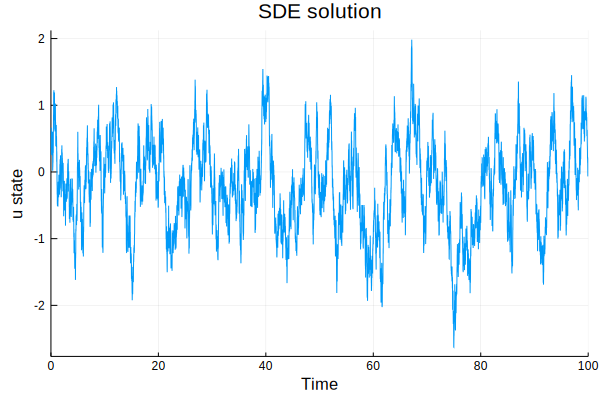

In [4]:
gr()
plot(sol, title = "SDE solution", label = "")
xlabel!("Time")
ylabel!("u state")

## Histogram based regression

In [5]:
# Regression function
function HBR(U::Array{T,1}, dt::Real, tau_in::Integer, Nbins::Integer, binLims::Tuple{T,T}) where T
    # Histogram based regression
    Urange = maximum(binLims) - minimum(binLims);
    dU = Urange/Nbins;
    Uleft = (0:(Nbins-1))*dU .+ binLims[1];
    Ucentre = Uleft .+ (dU/2);
    binEdges = collect([Uleft; binLims[2]]);

    h = fit(Histogram, U, binEdges);
    Uloc = StatsBase.binindex.(Ref(h), U);

    M1 = Array{T,1}(undef, Nbins);
    M2 = Array{T,1}(undef, Nbins);

    for ii = 1:Nbins
        iU = findall(x->x==ii, Uloc[1:end-tau_in]);
        inc = U[iU .+ tau_in] - U[iU];
        M1[ii] = mean(inc);
        M2[ii] = mean((inc .- M1[ii]).^2);
    end
    
    D1 = M1./(dt*tau_in);
    D2 = M2./(dt*tau_in);
    return Ucentre, D1, D2
end

HBR (generic function with 1 method)

In [6]:
U = sol.u;
tau_in = 1;
Nbins = 10;
binLims = (-1.0,1.0);

In [7]:
Ucentre, D1, D2 = HBR(U, dt, tau_in, Nbins, binLims);
# D1 = M1./(dt*tau_in);
# D2 = M2./(dt*tau_in);

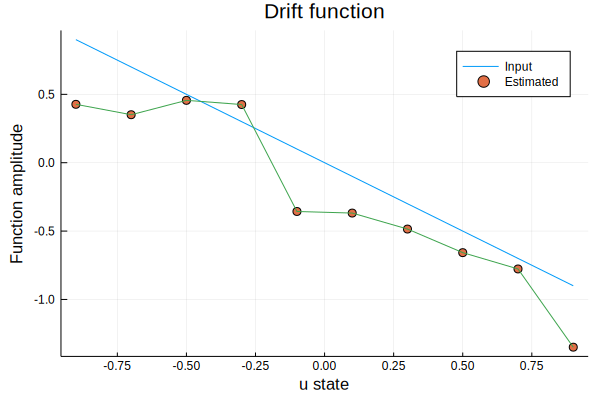

In [115]:
gr()
plot(Ucentre, f(collect(Ucentre),[],[]), title = "Drift function", label = "Input")
scatter!(Ucentre, D1, label = "Estimated")
plot!(Ucentre, D1, label = "")
xlabel!("u state")
ylabel!("Function amplitude")

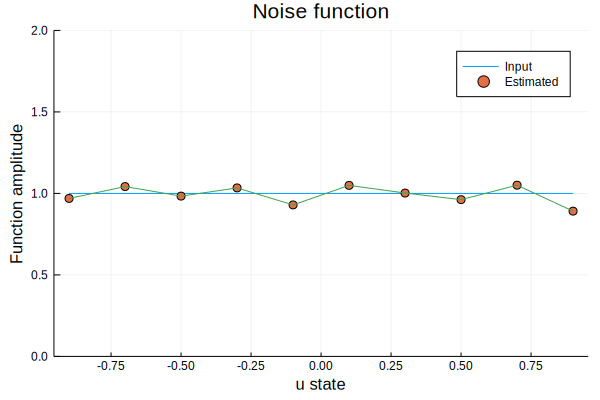

In [117]:
gr()
plot(Ucentre, map(x -> g(x,[],[]),collect(Ucentre)), title = "Noise function", label = "Input")
scatter!(Ucentre, D2, label = "Estimated")
plot!(Ucentre, D2, label = "")
xlabel!("u state")
ylabel!("Function amplitude")
ylims!(0,2)

## Linear regression

In [110]:
function linearSlope(x, y)
    N = length(x);
    Σx = sum(x);
    Σx² = sum(x.*x);
    Σy = sum(y);
    Σxy = sum(x.*y);
    B = (N*Σxy - Σx*Σy)/(N*Σx² - (Σx)^2);
    return B
end;

In [112]:
## Estimated slope
α̂ = linearSlope(Ucentre, D1);

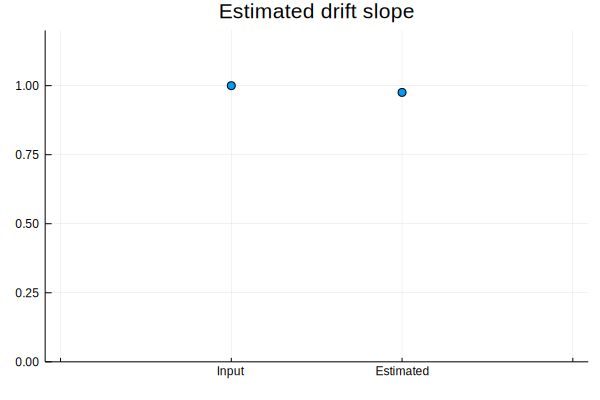

In [113]:
## Plotting
gr()
plt1 = scatter(["", "Input", "Estimated", "\\n"], [NaN, -α, -α̂, NaN], 
    label = "", title = "Estimated drift slope")
ylims!(0, 1.2)

## Bootstrapping 

In [118]:
## Include package
include("../src/bootstrapSampling.jl");
include("../src/bootstrapStatistic.jl");

In [123]:
## Define statistic
function slopeStatistic(X, dt, tau_in, Nbins, binLims)
    # Histogram based regression
    Ucentre, D1, D2 = HBR(U, dt, tau_in, Nbins, binLims);
    
    # Linear fit
    α̂ = -linearSlope(Ucentre, D1);
    return α̂
end

slopeStatistic (generic function with 2 methods)

In [125]:
slopeStatistic(U, dt, tau_in, Nbins, binLims)
length(U)

10001

In [129]:
## Bootstrap slope
inputData = U;
statisticHandle = slopeStatistic;
bootstrapSampleHandle = MBBsample;
blockLength = 100;
Nblocks = 100;
NbootstrapReplicates = 200;
fullDataEstimate, replicateEstimate, resampleIndexBB, resampleDataBB = bootstrapStatistic(
    inputData, statisticHandle, bootstrapSampleHandle, blockLength, Nblocks, NbootstrapReplicates);

UndefVarError: UndefVarError: testData not defined